In [41]:
# Library imports
import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import plotly.io as pio
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None  # default='warn'

# Get datasets from preprocessing
training = preprocessing.get_training_set()
test = preprocessing.get_test_set()
hh_char = preprocessing.INECDataSet('household_characteristics').get_dataset()
education = preprocessing.INECDataSet('edu').get_dataset()
edu_level = preprocessing.INECDataSet('edu_lvl').get_dataset()

# Verify successful load of datasets
assert not training.empty
assert not test.empty
assert not hh_char.empty
assert not education.empty
assert not edu_level.empty



Start to load data...
Processing... Please wait...
Start to load data...
Start to load data...


In [60]:
# Matplotlib setting
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
grp = training.groupby('Target')
g1 = grp.get_group(1)
g2 = grp.get_group(2)
g3 = grp.get_group(3)
g4 = grp.get_group(4)

In [4]:
avg_child = [ig['hogar_nin'].sum()/ig.shape[0] for ig in [g1,g2,g3,g4]]
avg_adult = [ig['hogar_adul'].sum()/ig.shape[0] for ig in [g1,g2,g3,g4]]
children = go.Bar(
    x=[1, 2, 3, 4],
    y=avg_child,
    name='Children'
)
adult = go.Bar(
    x=[1, 2, 3, 4],
    y=avg_adult,
    name='Adults'
)

layout = go.Layout(
    xaxis={'title': 'Income Group'},
    yaxis={'title': 'Average number per household'},
    barmode='stack'
)

fig = go.Figure(data=[children,adult], layout=layout)#, layout=layout)
py.iplot(fig)

In [5]:
t1 = go.Pie(labels=[2,3, 'other'], values=[34.23, 52.25, 100-34.23-52.25], hole=0.8)
t2 = go.Pie(labels=[2,3, 'other'], values=[38.69, 50.68, 100-38.96-50.68], hole=0.8, domain={'x': [0.11, 0.89], 'y': [0.11,0.89]})
t3 = go.Pie(labels=[2,3, 'other'], values=[44.51, 48.17, 100-44.51-48.17], hole=0.8, domain={'x': [0.2, 0.8], 'y': [0.2,0.8]})
t4 = go.Pie(labels=[2,3, 'other'], values=[56.04, 41.40, 100-56.04-41.40], domain={'x': [0.3, 0.7], 'y': [0.3,0.7]}, rotation = 100)

# layout = go.Layout(
#     xaxis={'title': 'Income Group'},
#     yaxis={'title': 'Average number per household'},
#     barmode='stack'
# )


fig = go.Figure(data=[t1, t2, t3, t4])#, layout=layout)
py.iplot(fig)

# Household income

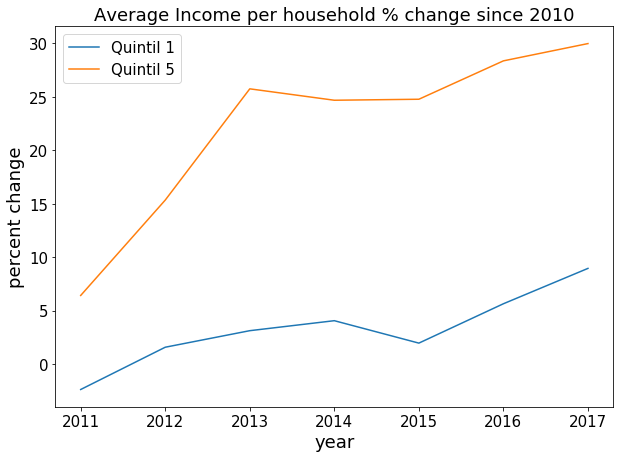

In [73]:
def get_region(df, region_col_name, regions_to_get):
    """
    Given a pandas DataFrame, get the <regions_to_get> from <region_col_name>. Return the result as a DataFrame
    :param df: Pandas DataFrame to work on
    :type df: Pandas DataFrame
    :param region_col_name: Name of the column to get region from
    :type region_col_name: str
    :param regions_to_get: List of regions to get from df
    :type regions_to_get: List of str
    """
    assert isinstance(df, pd.core.frame.DataFrame)
    assert not df.empty
    assert isinstance(region_col_name, str)
    assert region_col_name in df.columns, f'{region_col_name} not in dataframe columns'
    region_grp = df.groupby(region_col_name)
    assert [region in region_grp.groups.keys() for region in regions_to_get], '{regions_to_get} not found in column {region_col_name}!'
    
    region_df = pd.concat([region_grp.get_group(region_name) for region_name in regions_to_get])
    assert not region_df.empty
    return region_df

average_income_household = get_region(hh_char, 'Category', ['Income per household', 'Average income per household',
                                                           'Average total household income'])
average_income_household_person = get_region(hh_char, 'Category', ['Per capita income per household',
                                                                  'Average household income per capita'])
average_income_household.loc[:,['Total', 'Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']] = average_income_household.loc[:,['Total', 'Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']].astype(float)
average_income_household_person.loc[:,['Total', 'Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']] = average_income_household_person.loc[:,['Total', 'Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']].astype(float)

cr_avg_income_pct_change = get_region(average_income_household, 'region', ['Whole Costa Rica']).set_index('year').drop(['Category','region'],axis=1)
for year in range(2011,2018):
    cr_avg_income_pct_change.loc[year,:] = (cr_avg_income_pct_change.loc[year,:] / cr_avg_income_pct_change.loc[2010,:] - 1) * 100

cr_avg_income_pct_change = cr_avg_income_pct_change.drop(2010)
fig, ax = plt.subplots(figsize=(10,7))
cr_avg_income_pct_change['Quintil 1'].plot.line(ax=ax)
cr_avg_income_pct_change['Quintil 5'].plot.line(ax=ax)
ax.set_title('Average Income per household % change since 2010', fontsize=18)
ax.legend(labels=['Quintil 1', 'Quintil 5'])
ax.set_ylabel('percent change');
plt.savefig(os.getcwd() + '/plots/Income percent change quintil.png')
    

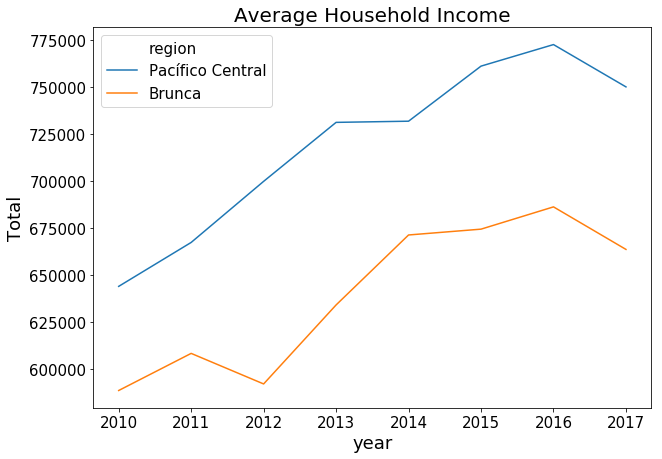

In [71]:
#sns.boxplot(x = 'year', y = 'Total' , data = average_income_household)
c_average_income_household = average_income_household.copy()

c_average_income_household = c_average_income_household.loc[(c_average_income_household['region'] == 'Pacífico Central')|
                                                            ((c_average_income_household['region'] == 'Brunca')),:]
c_average_income_household_person = average_income_household_person.copy()
c_average_income_household_person = c_average_income_household_person.loc[(c_average_income_household_person['region'] == 'Pacífico Central')|
                                                            ((c_average_income_household_person['region'] == 'Brunca')),:]

fig, ax = plt.subplots(figsize = (10, 7))
sns.lineplot(x="year", y="Total", hue="region" ,data = c_average_income_household, ax=ax)
ax.set_title('Average Household Income', fontsize=20)
plt.savefig(os.getcwd() + '/plots/Avg_Income_Parallel_1.png');

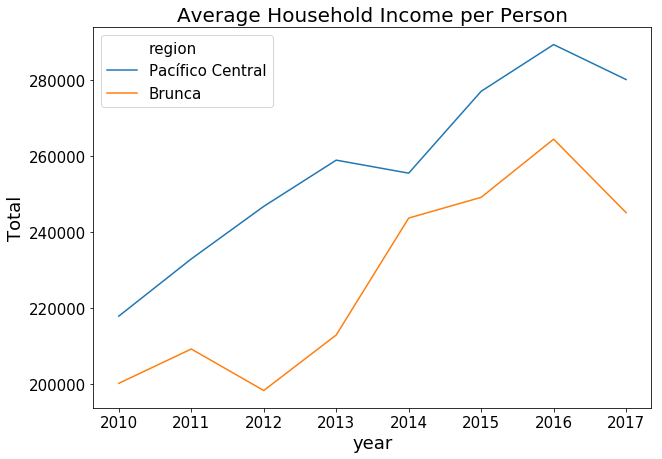

In [70]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.lineplot(x="year", y="Total", hue="region" ,data = c_average_income_household_person, ax=ax)
ax.set_title('Average Household Income per Person', fontsize = 20)
plt.savefig(os.getcwd() + '/plots/Avg_Income_Parallel_2.png')

# Overcrowding: Number of person per room

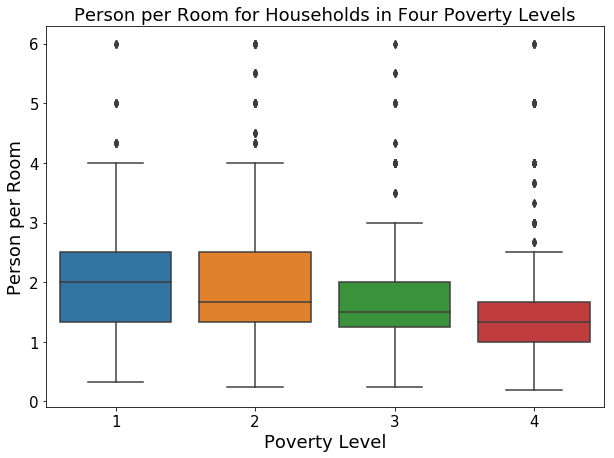

In [69]:
fig, ax = plt.subplots(figsize=[10,7])
sns.boxplot(x='Target', y='overcrowding', data=training, ax=ax)
ax.set_ylabel('Person per Room')
ax.set_xlabel('Poverty Level')
ax.set_title('Person per Room for Households in Four Poverty Levels', fontsize=18)
plt.savefig(os.getcwd() + '/plots/household_overcrowding.png')

In [45]:
## year = list(range(2010,2018))
pov = [21.2, 21.7, 20.6, 20.7, 22.4, 21.7, 20.5, 20.0]
poverty_old = go.Scatter(
    x = year[:5],
    y = pov[:5],
    mode = 'lines+markers',
    name = '% Poverty',
    line = dict(width = 4)
)
layout = go.Layout(
    width=500,
    height=500,
    xaxis=dict(title='Year'),
    yaxis=dict(title='Total poverty %'),
    title='Costa Rica Total Poverty % under Laura Chinchilla',
    titlefont=dict(size=14))

fig = go.Figure(data=[poverty_old], layout=layout)
py.iplot(fig)

In [36]:
year = list(range(2010,2018))
pov = [21.2, 21.7, 20.6, 20.7, 22.4, 21.7, 20.5, 20.0]
poverty_new = go.Scatter(
    x = year[4:],
    y = pov[4:],
    mode = 'lines+markers',
    name = '% Poverty',
    line = dict(
        color = ('green'),
        width = 4)
)
layout = go.Layout(
    width=500,
    height=500,
    xaxis=dict(title='Year'),
    yaxis=dict(title='Total poverty %'),
    title='Costa Rica Total Poverty % under Luis Guillermo Solis',
    titlefont=dict(size=14))

fig = go.Figure(data=[poverty_new], layout=layout)
py.iplot(fig)

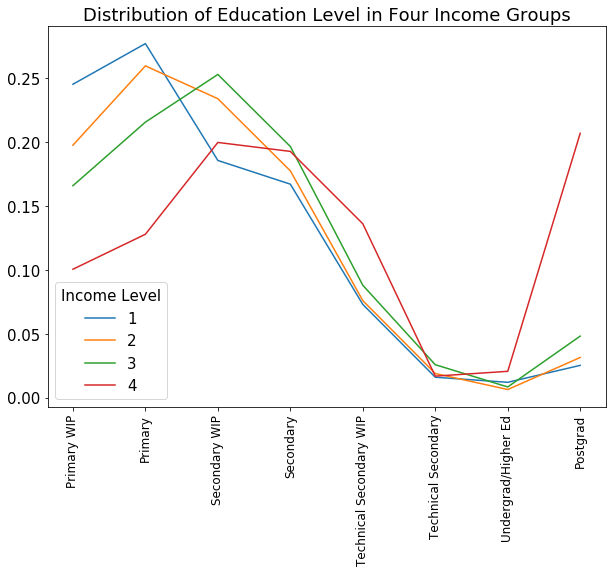

In [153]:
training['instlevel'] = training['instlevel1'] * 1 + training['instlevel2'] * 2 + training['instlevel3'] * 3 + training['instlevel4'] * 4 + training['instlevel5'] * 5 + training['instlevel6'] * 6 + training['instlevel7'] * 7 + training['instlevel8'] * 8 + training['instlevel9'] * 9
inst = pd.DataFrame()
for target in range(1,5):
    inst[target] = training.loc[training['Target'] == target,'instlevel'].value_counts().sort_index()
    total_samples = inst[target].sum()
    inst[target] = inst[target].apply(lambda x:x/total_samples)

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Distribution of Education Level in Four Income Groups', fontsize=18)
# ax.set_xticks(['a','a','a','a','a','a','a','a'],x)
x_ticks_labels = ['No Edu','Primary WIP','Primary',
                  'Secondary WIP','Secondary',
                  'Technical Secondary WIP', 'Technical Secondary',
                 'Undergrad/Higher Ed', 'Postgrad']
# ax.set_xticks(x_ticks_labels)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=12)
inst.plot.line(ax=ax);
plt.xticks(rotation=90);
ax.legend(title='Income Level');
plt.savefig(os.getcwd() + '/plots/edu.png')

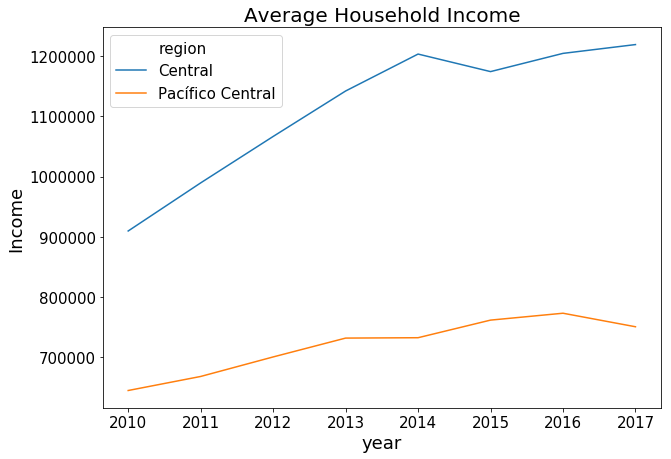

In [172]:
# hh_char[hh_char.Category == 'Income per household'][hh_char.region == 'Whole Costa Rica']
central_income = average_income_household.loc[(average_income_household.region == 'Central') | (average_income_household.region == 'Pacífico Central')]
# 
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='year',y='Total',hue='region',data=central_income)
ax.set_title('Average Household Income', fontsize=20)
ax.set_ylabel('Income');
plt.savefig(os.getcwd() + '/plots/economy_income.png')